In [1]:
import sys
sys.path.append('../')
from read_data_functions import *
from plot_functions import *
from calculations import *
plt.style.use('../Style.mplstyle')
import warnings
warnings.filterwarnings('ignore')
pd.options.mode.chained_assignment = None  # suppress warnings

In [2]:
path = '../../../Data/2025/250929-251003_Ulva/'
gcms_raw = import_data(f'{path}GC-MS/', '', None, None, None)
gcms_raw = gcms_raw['250929-251003_Ulva_results']
flow_data = import_data(f'{path}Absorbent tube flows/', '', 'Time', '%d-%m-%Y %H:%M:%S', 0)

In [3]:
timestamps = [['2025-09-29 17:11', '2025-09-29 19:11'],   # [P] = 3.9 uM, R1
              
              ['2025-09-30 09:37', '2025-09-30 11:34'],   # Blank1
              ['2025-09-30 12:41', '2025-09-30 14:38'],   # [P] = 0.02 uM, R2
              ['2025-09-30 16:15', '2025-09-30 18:14'],   # [P] = 19 uM, R1 

              ['2025-10-01 09:33', '2025-10-01 11:31'],   # [P] = 3.9 uM, R2
              ['2025-10-01 12:44', '2025-10-01 14:46'],   # Blank2
              ['2025-10-01 15:49', '2025-10-01 17:49'],   # [P] = 0.7 uM, R2

              ['2025-10-02 09:53', '2025-10-02 12:06'],   # [P] = 19 uM, R2
              ['2025-10-02 13:24', '2025-10-02 15:27'],   # [P] = 3.9 uM, R3
              ['2025-10-02 16:52', '2025-10-02 18:57'],   # [P] = 0.02 uM, R3

              ['2025-10-03 10:01', '2025-10-03 12:03'],   # [P] = 0.7 uM, R3  
              ['2025-10-03 13:18', '2025-10-03 15:17'],   # [P] = 19 uM, R3
              ['2025-10-03 16:59', '2025-10-03 18:59']    # Blank3
]

flow_keys = ['250929_P39_Ulva_A028727T_A028689C', 
             '250930_Blank1_Ulva_A029641T_A028596C', '250930_P002_Ulva_A028572T_A028052C', '250930_P19_Ulva_A028476T_A030827C', 
             '251001_P39_Ulva_A029668T_A030947C', '251001_Blank2_Ulva_A030818T_A031826C', '251001_P07_Ulva_A028453T_A029151C',
             '251002_P19_Ulva_A029717T_A029836C', '251002_P39_Ulva_A028586T_A029651C', '251002_P002_Ulva_A029658T_A030854C',
             '251003_P07_Ulva_A029817T_A029691C', '251003_P19_Ulva_A029803T_A028597C', '251003_Blank3_Ulva_A029154T_A028440C']

# Drymatter content in g
drymatter_content = [0.2333,
                     0.2679, 0.4601,
                     0.3914, 0.4145,
                     0.3736, 0.3739, 0.3868,
                     0.384, 0.4165]

gcms = GCMS_concentration_calculation(flow_data, flow_keys, ' Flow [L/min]', timestamps, gcms_raw, 'TA and CA', 0.5)
blank_sum_TA = gcms.loc[['250930_TAA029641_Blank1', '251001_TAA030818_Blank2', '251003_TAA029154_Blank3']].sum() / 3
gcms_TA = gcms[::2].drop(['250930_TAA029641_Blank1', '251001_TAA030818_Blank2', '251003_TAA029154_Blank3'])

P_concentrations = []
for index in gcms_TA.index:
    P_conc = index.split('_')[2]
    P_concentrations.append(P_conc.split('-')[0])
gcms_TA['P concentration'] = P_concentrations
gcms_TA = gcms_TA.reset_index(drop = True)

for index, row in gcms_TA.iterrows():
    corrected = row[:-1] - blank_sum_TA
    gcms_TA.loc[index][gcms_TA.keys()[:-1]] = corrected / drymatter_content[index]

mean_gcms = pd.DataFrame(columns = gcms_TA.keys()[:-1])
for P_conc, group in gcms_TA.groupby('P concentration'):
    mean_conc = []
    for key in group.keys()[:-1]:
        mean_conc.append(group[key].mean())
    mean_gcms.loc[len(mean_gcms)] = mean_conc
P39, P19 = mean_gcms.loc[3], mean_gcms.loc[2]
mean_gcms.loc[2], mean_gcms.loc[3] = P39, P19

Molecular_weights = [96.94, 84.93, 96.94, 98.96, 119.37, 133.40, 153.81, 98.95, 131.38, 112.98, 163.8, 106.549, 110.97, 110.97, 133.40, 165.82, 208.28, 112.56, 252.731, 167.848, 267.836, 147.01, 147.01, 147.01]
for MW, key in zip(Molecular_weights, mean_gcms.keys()):
    mean_gcms[key] = ((mean_gcms[key]*8.314*283.55) / (MW*101325)) * 10**(6) # Concentration in ppt

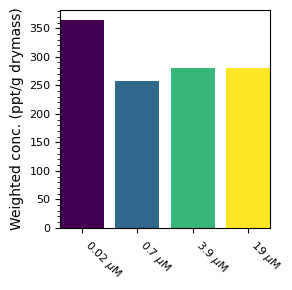

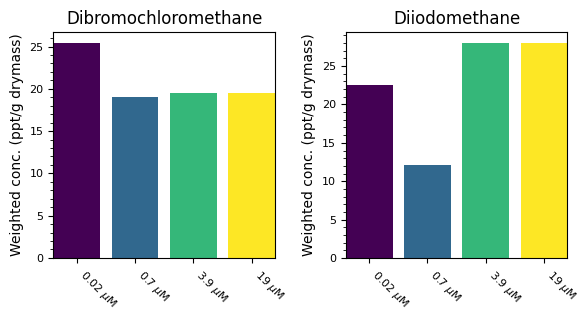

In [4]:
P_conc = [r'0.02 $\mu$M', r'0.7 $\mu$M', r'3.9 $\mu$M', r'19 $\mu$M']

fig, ax = plt.subplots(figsize = (3, 3))
plot_barchart(ax, mean_gcms['Methane, tribromo- Results'], np.zeros(4), P_conc, 'Weighted conc. (ppt/g drymass)')
fig.tight_layout()
fig.savefig('Figures/GC-MS_bromoform.jpg', dpi = 600)

fig1, ax1 = plt.subplots(1,2, figsize = (6, 3.3))
plot_multi_barchart(ax1, pd.DataFrame({'dibromochloro': mean_gcms['Methane, dibromochloro- Results'], 'diiodo': mean_gcms['Methane, diiodo- Results']}),
                    pd.DataFrame({'dibromochloro': np.zeros(4), 'diiodo': np.zeros(4)}), P_conc, 'Weighted conc. (ppt/g drymass)')
ax1[0].set(title = 'Dibromochloromethane')
ax1[1].set(title = 'Diiodomethane')
fig1.tight_layout()
fig1.savefig('Figures/GC-MS_dibromochloro+diiodomethane.jpg', dpi = 600)